In [1]:
!pip install torch_geometric pandas numpy matplotlib

In [2]:
import sys
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [10]:
# CONSTANTS

# Need to download Dataset.py from GEMS directory locally onto vm first
# git clone http://github.com/camlab-ethz/GEMS.git
# Define root path of cloned GEMS repo
GEMS_REPO_ROOT = os.path.expanduser('~/GEMS')

# Define the directory path where pre-processed .pt dataset files are located
DATA_DIR = os.path.join(os.path.expanduser('~'), 'gcs_pdbbind_mount')

# List of dataset files to analyze
DATASET_FILES = [
    '00AEPL_casf2013.pt',
    # '00AEPL_casf2013_indep.pt',
    # '00AEPL_casf2016.pt',
    # '00AEPL_casf2016_indep.pt',
    # '00AEPL_train_cleansplit.pt',
    # '00AEPL_train_pdbbind.pt'
]


In [11]:
# Dynamic Import of Custom Datasets Class
# Add the directory to Python's search path.
print(f"Attempting to load custom Dataset class...")

try:
  # Add GEMS root to sys.path
  if GEMS_REPO_ROOT not in sys.path:
    sys.path.append(GEMS_REPO_ROOT)
    print(f"Added {GEMS_REPO_ROOT} to sys.path")

    # Import custom Dataset class from the cloned repo
    from Dataset import Dataset as GEMS_Dataset
    print("Successfully imported custom Dataset class")

    # Import the necessarty PyG components
    from torch_geometric.data import Data #, Dataset

except ImportError as e:
    raise RuntimeError(f"FATAL ERROR importing GEMS Dataset class: {e}")
    

Attempting to load custom Dataset class...


In [16]:
def extract_metrics(data_list):
   """Iterates through list of GEMS datasets and extracts metrics."""
   metrics = []

   num_features = data_list[0].x.size(1)

   for i, data in enumerate(data_list):

      # Affinity is the y label
      affinity = data.y.item()

      # ID (Assuming is stored in 'id' attribute)
      pdb_id = getattr(data, 'id', f'Complex_{i}')

      # Extract Graph Size Metrics
      # node features (x): shape is [num_atoms, num_features]
      num_nodes = data.x.size(0)

      # Edge index: shape is: [2, num_edges]
      num_edges = data.edge_index.size(1)

      # Atom feature counts
      feature_counts_tensor = torch.sum(data.x, dim=0)

      # Append the aggregated features to the list
      record = {
        'PDB_ID': pdb_id,
        'Affinity_pKi_pKd': affinity,
        'Num_Atoms': num_nodes,
        'Num_Interactions': num_edges,
        'Density': num_edges / num_nodes,
      }

      # Add feature counts dynamically
      for j in range(num_features):
        record[f'Feature_{j}'] = feature_counts_tensor[j].item()

      metrics.append(record)

   return pd.DataFrame(metrics)

In [20]:
def run_data_analysis(df, dataset_name):
  """Performs data analysis on dataframe and produces visualizations"""

  print(f"Analyzing {dataset_name} dataset (N={len(df)})...")

  # Affinity Distribution
  print("\n[1] Affinity Distribution")
  print(df['Affinity_pKi_pKd'].describe())

  plt.figure(figsize=(12, 4))
  plt.subplot(1, 2, 1)
  df['Affinity_pKi_pKd'].hist(bins=50)
  plt.title(f'{dataset_name}: Affinity Distribution')
  plt.xlabel('Binding Affinity (pKi/pKd)')
  plt.ylabel('Frequency')


  # Graph Size Metrics
  print("\n[2] Graph Size Metrics")
  print(df[['Num_Atoms', 'Num_Interactions', 'Density']].describe())

  df[['Num_Atoms', 'Num_Interactions', 'Density']].hist(bins=50)

  plt.tight_layout()
  plt.show()

  # Protein Diversity
  # Use PDB_ID count to determine protein complexes
  unique_complexes = df['PDB_ID'].nunique()
  print(f"\n[3] Protein Diversity: {unique_complexes} unique proteins")
  print(f"Redundancy Ratio (Total N / Unique N): {len(df) / unique_complexes:.2f}")

  # Node Feature Frequency
  # Summing up total count for the top 5 most frequent features
  feature_cols = [col for col in df.columns if col.startswith('Feature_')]
  top_5_features = df[feature_cols].sum().nlargest(5).index.tolist()

  print("\n[4] Node Feature Frequency")
  print(f"Top 5 Features: {', '.join(top_5_features)}")
  # TODO: map features to actual atom types


Loading 00AEPL_casf2013.pt...
Example data object type: <class 'torch_geometric.data.data.Data'>
Analyzing 00AEPL_casf2013.pt dataset (N=194)...

[1] Affinity Distribution
count    194.000000
mean       0.394762
std        0.139924
min        0.129375
25%        0.288437
50%        0.392188
75%        0.499375
max        0.720000
Name: Affinity_pKi_pKd, dtype: float64

[2] Graph Size Metrics
        Num_Atoms  Num_Interactions     Density
count  194.000000        194.000000  194.000000
mean    46.319588        388.123711    8.330230
std     16.033997        142.787698    0.739575
min     24.000000        164.000000    6.148936
25%     33.000000        266.250000    7.827324
50%     43.000000        362.500000    8.366071
75%     57.000000        476.000000    8.825829
max    104.000000        812.000000    9.967742


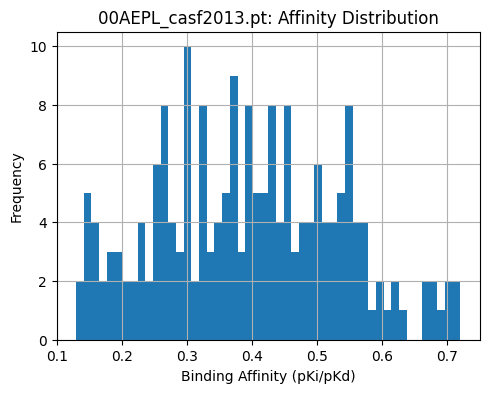

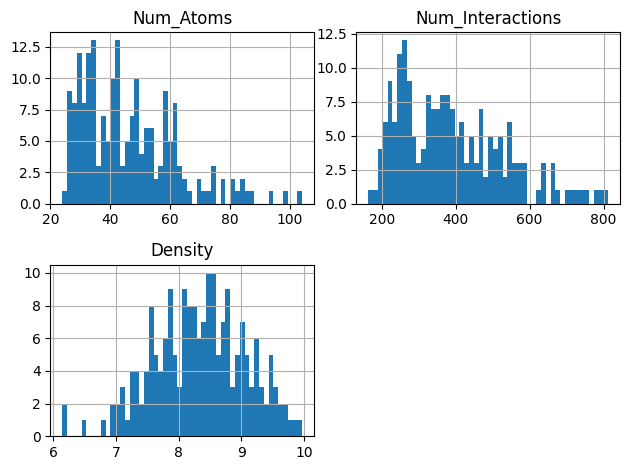


[3] Protein Diversity: 194 unique proteins
Redundancy Ratio (Total N / Unique N): 1.00

[4] Node Feature Frequency
Top 5 Features: Feature_36, Feature_1, Feature_12, Feature_9, Feature_28
--------------| Data analysis completed! |------------


In [21]:
# Main loop
if not os.path.exists(DATA_DIR):
    raise RuntimeError(f"FATAL ERROR: Path {DATA_DIR} does not exist.")

for filename in DATASET_FILES:
    data_filepath = os.path.join(DATA_DIR, filename)

    if not os.path.exists(data_filepath):
        print(f"WARNING: File not found: {data_filepath}. Skipping...")
        continue

    print(f"Loading {filename}...")
    try:
        # Load data_list
        data_list = torch.load(data_filepath)
        print(f"Example data object type: {type(data_list[0])}")

        # Run analysis
        df = extract_metrics(data_list)
        run_data_analysis(df, filename)

    except Exception as e:
        print(f"\nFAILED PROCESSING {filename}: {e}")

print("--------------| Data analysis completed! |------------")